In [290]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [291]:
from rag.pdf import PDFRetrievalChain

### PDF 문서 검색 Retrieval Chain 생성

In [292]:
# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

In [293]:
pdf_retriever = pdf.retriever       # retriever 생성

In [294]:
pdf_chain = pdf.chain               # pdf retriever chain 생성

In [295]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# PDF 문서를 검색하는 검색 도구 생성
retriever_tool = create_retriever_tool(        
    pdf_retriever,
    "pdf_retriever",
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

tools = [retriever_tool]            # 문서 검색 도구를 리스트에 추가. 에이전트에서 사용가능하게 한다.

In [296]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from typing import Annotated, Sequence, TypedDict
from pydantic import BaseModel, Field
from typing import Literal

from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage
from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition

from langchain import hub

In [297]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [298]:
def agent(state: AgentState):
    messages = state["messages"]

    print('=================================================================================')
    print(f"agent() 함수 실행: ")
    print(f"전달받은 state 에서 꺼내온 messages:")
    print(messages)

    llm = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )

    llm = llm.bind_tools(tools)         # 문서 검색 도구 바인딩     

    response = llm.invoke(messages)     # llm을 실행해서 agent 답변을 가져온다

    print('=================================================================================')

    return {"messages": [response]}     # 리스트로 답변을 만든다

In [299]:
initial_state = AgentState(messages=[
    HumanMessage(content="삼성전자가 만든 생성형 AI에 대해서 알려줘")
])

result = agent(initial_state)

agent() 함수 실행: 
전달받은 state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 만든 생성형 AI에 대해서 알려줘', additional_kwargs={}, response_metadata={})]


In [300]:
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Jf7fJlo5UdR5X5ciMVbkPwu0', 'function': {'arguments': '{"query":"삼성전자 생성형 AI"}', 'name': 'pdf_retriever'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306'}, id='run-89dfb7c9-62aa-4124-82fc-72016cd63203-0', tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI'}, 'id': 'call_Jf7fJlo5UdR5X5ciMVbkPwu0', 'type': 'tool_call'}])]}

In [301]:
class grade(BaseModel):
    """A binary score for relevance checks"""

    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )

In [302]:
def grade_documents(state: AgentState) -> Literal["generate", "rewrite"]:
    print('=================================================================================')
    print(f"grade_documents() 함수 실행: ")
    print(f"state['message'] 를 꺼낸다")

    messages = state["messages"]
    
    # 원래 질문 추출
    question = messages[0].content

    # 가장 마지막 메시지 추출
    last_message = messages[-1]

    # 검색된 문서 추출
    retrieved_docs = last_message.content

    print(f"원래 질문 : {question}")
    print(f"가장 마지막 질문: ")
    print(last_message)

    print(f"검색된 문서: ")
    print(retrieved_docs)
    print()

    model = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )

    llm_with_tool = model.with_structured_output(grade)


    # 프롬프트 템플릿 정의
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # llm + tool 바인딩 체인 생성
    chain = prompt | llm_with_tool

    # 관련성 평가 실행
    scored_result = chain.invoke({"question": question, "context": retrieved_docs})

    score = scored_result.binary_score

    print(f"score: {score}")
    print()

    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        print('리턴 값 : generate')
        print('=================================================================================')
        return "generate"

    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print('리턴 값 : rewrite')
        print('=================================================================================')
        print(score)
        return "rewrite"


In [303]:
initial_state = AgentState(messages=[
    HumanMessage(content="SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘"),
    AIMessage(content="""최근 AI 트렌드에 대한 정보는 다음과 같습니다:

1. 생성형 AI의 급속한 발전: ChatGPT, DALL-E 등의 모델이 텍스트, 이미지 생성 능력을 크게 향상시켰습니다.
2. AI 규제 논의 확대: AI의 윤리적 사용과 개인정보 보호에 대한 규제 논의가 활발해지고 있습니다.
3. AI의 산업 적용 확대: 제조, 금융, 의료 등 다양한 산업 분야에서 AI 기술 도입이 가속화되고 있습니다.
4. 엣지 AI의 발전: 클라우드에 의존하지 않고 로컬 디바이스에서 AI 처리를 수행하는 기술이 발전하고 있습니다.
5. AI 모델의 경량화: 모바일 기기 등에서도 효율적으로 작동할 수 있는 경량 AI 모델 개발이 진행 중입니다.

이 정보는 SPRI AI Brief PDF 문서에서 추출한 것입니다.""")
])

In [304]:
grade_documents(initial_state)

grade_documents() 함수 실행: 
state['message'] 를 꺼낸다
원래 질문 : SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘
가장 마지막 질문: 
content='최근 AI 트렌드에 대한 정보는 다음과 같습니다:\n\n1. 생성형 AI의 급속한 발전: ChatGPT, DALL-E 등의 모델이 텍스트, 이미지 생성 능력을 크게 향상시켰습니다.\n2. AI 규제 논의 확대: AI의 윤리적 사용과 개인정보 보호에 대한 규제 논의가 활발해지고 있습니다.\n3. AI의 산업 적용 확대: 제조, 금융, 의료 등 다양한 산업 분야에서 AI 기술 도입이 가속화되고 있습니다.\n4. 엣지 AI의 발전: 클라우드에 의존하지 않고 로컬 디바이스에서 AI 처리를 수행하는 기술이 발전하고 있습니다.\n5. AI 모델의 경량화: 모바일 기기 등에서도 효율적으로 작동할 수 있는 경량 AI 모델 개발이 진행 중입니다.\n\n이 정보는 SPRI AI Brief PDF 문서에서 추출한 것입니다.' additional_kwargs={} response_metadata={}
검색된 문서: 
최근 AI 트렌드에 대한 정보는 다음과 같습니다:

1. 생성형 AI의 급속한 발전: ChatGPT, DALL-E 등의 모델이 텍스트, 이미지 생성 능력을 크게 향상시켰습니다.
2. AI 규제 논의 확대: AI의 윤리적 사용과 개인정보 보호에 대한 규제 논의가 활발해지고 있습니다.
3. AI의 산업 적용 확대: 제조, 금융, 의료 등 다양한 산업 분야에서 AI 기술 도입이 가속화되고 있습니다.
4. 엣지 AI의 발전: 클라우드에 의존하지 않고 로컬 디바이스에서 AI 처리를 수행하는 기술이 발전하고 있습니다.
5. AI 모델의 경량화: 모바일 기기 등에서도 효율적으로 작동할 수 있는 경량 AI 모델 개발이 진행 중입니다.

이 정보는 SPRI AI Brief PDF 문서에서 추출한 것입니다.

score: yes

==== [DECISION: DOCS RELEVANT

'generate'

In [306]:
def rewrite(state: AgentState):
    print('=================================================================================')
    print("==== [QUERY REWRITE] 함수 실행 ====")

    messages = state["messages"]

    question = messages[0].content              # 원래 질문 추출

    # 질문 개선을 위한 프롬프트 구성
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    print(f"원래 메시지 : {question}")

    # LLM 모델로 질문 개선
    model = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )
    
    # Query-Transform 체인 실행
    response = model.invoke(msg)

    print(f"rewrite() 함수 실행 후 재작성 된 질문: ")
    print(response)
    print('=================================================================================')

    return {"messages": [response]}             # 재작성 된 질문 리턴

In [ ]:
initial_state = AgentState(messages=[
    HumanMessage(content="SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘")
])

# grade_documents 함수 호출
grade_result = grade_documents(initial_state)

grade_result = "rewrite"                    

# grade_documents 결과에 따라 rewrite 함수 호출
if grade_result == "rewrite":
    rewrite_result = rewrite(initial_state)
    print("Rewritten query:")
    print(rewrite_result['messages'][0].content)
else:
    print("No rewrite needed. Proceeding with original query.")

grade_documents() 함수 실행: 
state['message'] 를 꺼낸다
원래 질문 : SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘
가장 마지막 질문: 
content='SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘' additional_kwargs={} response_metadata={}
검색된 문서: 
SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘

score: yes

==== [DECISION: DOCS RELEVANT] ====
리턴 값 : generate
==== [QUERY REWRITE] 함수 실행 ====
원래 메시지 : SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘
rewrite() 함수 실행 후 재작성 된 질문: 
content='"SPRI AI Brief PDF에서 최근 AI 트렌드에 대한 주요 내용을 요약해 주실 수 있나요?"' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306'} id='run-9d80d1be-df42-445b-8c1a-4747092b3711-0'
Rewritten query:
"SPRI AI Brief PDF에서 최근 AI 트렌드에 대한 주요 내용을 요약해 주실 수 있나요?"


In [309]:
def generate(state):
    
    print('=================================================================================')
    print(f"generate() 함수")

    messages = state["messages"]        

    question = messages[0].content      # 원래 질문

    docs = messages[-1].content         # 가장 최근 메시지

    # prompt = hub.pull("teddynote/rag-prompt")
    
    prompt = PromptTemplate(
        input_variables=['context', 'question'],
        template="""You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
        Your primary mission is to answer questions based on provided context or chat history.
        Ensure your response is concise and directly addresses the question without any additional narration.

        ###

        Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

        # Steps

        1. Carefully read and understand the context provided.
        2. Identify the key information related to the question within the context.
        3. Formulate a concise answer based on the relevant information.
        4. Ensure your final answer directly addresses the question.
        5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

        # Output Format:
        [Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

        **Source**(Optional)
        - (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
        - (list more if there are multiple sources)
        - ...

        ###

        Remember:
        - It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
        - DO NOT use any external knowledge or information not present in the given materials.
        - If you can't find the source of the answer, you should answer that you don't know.

        ###

        # Here is the user's QUESTION that you should answer:
        {question}

        # Here is the CONTEXT that you should use to answer the question:
        {context}

        # Your final ANSWER to the user's QUESTION:"""
        )
    

    llm = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )

    # RAG 체인 구성
    rag_chain = prompt | llm | StrOutputParser()

    print(f"원래 질문 : {question}")
    print(f"가장 최근 메시지: \n {docs}")
    print("프롬프트:")
    print(prompt)

    # 답변 생성 실행
    response = rag_chain.invoke({"context": docs, "question": question})

    print(f"결과 : \n {response}")
    
    print('=================================================================================')
    
    return {"messages": [response]}

In [311]:
initial_state = AgentState(messages=[
    HumanMessage(content="SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘"),
    AIMessage(content="""최근 AI 트렌드에 대한 정보는 다음과 같습니다:

1. 생성형 AI의 급속한 발전: ChatGPT, DALL-E 등의 모델이 텍스트, 이미지 생성 능력을 크게 향상시켰습니다.
2. AI 규제 논의 확대: AI의 윤리적 사용과 개인정보 보호에 대한 규제 논의가 활발해지고 있습니다.
3. AI의 산업 적용 확대: 제조, 금융, 의료 등 다양한 산업 분야에서 AI 기술 도입이 가속화되고 있습니다.
4. 엣지 AI의 발전: 클라우드에 의존하지 않고 로컬 디바이스에서 AI 처리를 수행하는 기술이 발전하고 있습니다.
5. AI 모델의 경량화: 모바일 기기 등에서도 효율적으로 작동할 수 있는 경량 AI 모델 개발이 진행 중입니다.

이 정보는 SPRI AI Brief PDF 문서에서 추출한 것입니다.""")
])

# grade_documents 함수 호출
grade_result = grade_documents(initial_state)

grade_result = "rewrite"

# grade_documents 결과에 따라 rewrite 또는 generate 함수 호출
if grade_result == "rewrite":
    print("Rewriting query...")
    rewrite_result = rewrite(initial_state)
    print("Rewritten query:")
    print(rewrite_result['messages'][0].content)
    
    # 재작성된 쿼리로 새로운 상태 생성
    new_state = AgentState(messages=[
        HumanMessage(content=rewrite_result['messages'][0].content),
        initial_state['messages'][-1]  # 원래의 AI 응답 유지
    ])
    
    # 재작성된 쿼리로 generate 함수 호출
    generate_result = generate(new_state)
else:
    print("No rewrite needed. Proceeding with original query.")
    generate_result = generate(initial_state)

print("Final generated response:")
print(generate_result['messages'][0])

grade_documents() 함수 실행: 
state['message'] 를 꺼낸다
원래 질문 : SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘
가장 마지막 질문: 
content='최근 AI 트렌드에 대한 정보는 다음과 같습니다:\n\n1. 생성형 AI의 급속한 발전: ChatGPT, DALL-E 등의 모델이 텍스트, 이미지 생성 능력을 크게 향상시켰습니다.\n2. AI 규제 논의 확대: AI의 윤리적 사용과 개인정보 보호에 대한 규제 논의가 활발해지고 있습니다.\n3. AI의 산업 적용 확대: 제조, 금융, 의료 등 다양한 산업 분야에서 AI 기술 도입이 가속화되고 있습니다.\n4. 엣지 AI의 발전: 클라우드에 의존하지 않고 로컬 디바이스에서 AI 처리를 수행하는 기술이 발전하고 있습니다.\n5. AI 모델의 경량화: 모바일 기기 등에서도 효율적으로 작동할 수 있는 경량 AI 모델 개발이 진행 중입니다.\n\n이 정보는 SPRI AI Brief PDF 문서에서 추출한 것입니다.' additional_kwargs={} response_metadata={}
검색된 문서: 
최근 AI 트렌드에 대한 정보는 다음과 같습니다:

1. 생성형 AI의 급속한 발전: ChatGPT, DALL-E 등의 모델이 텍스트, 이미지 생성 능력을 크게 향상시켰습니다.
2. AI 규제 논의 확대: AI의 윤리적 사용과 개인정보 보호에 대한 규제 논의가 활발해지고 있습니다.
3. AI의 산업 적용 확대: 제조, 금융, 의료 등 다양한 산업 분야에서 AI 기술 도입이 가속화되고 있습니다.
4. 엣지 AI의 발전: 클라우드에 의존하지 않고 로컬 디바이스에서 AI 처리를 수행하는 기술이 발전하고 있습니다.
5. AI 모델의 경량화: 모바일 기기 등에서도 효율적으로 작동할 수 있는 경량 AI 모델 개발이 진행 중입니다.

이 정보는 SPRI AI Brief PDF 문서에서 추출한 것입니다.

score: yes

==== [DECISION: DOCS RELEVANT

In [312]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [317]:
workflow = StateGraph(AgentState)

In [318]:
workflow.add_node("agent", agent)       # 에이전트 노드
retrieve = ToolNode([retriever_tool])       
workflow.add_node("retrieve", retrieve) # 검색 노드
workflow.add_node("rewrite", rewrite)   # 질문 재작성 노드
workflow.add_node("generate", generate) # 관련 문서 확인 후 응답 생성 노드

# 엣지 연결
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,                     # 에이전트 결정 평가
    {                                            
        "tools": "retrieve",             # 조건 출력을 그래프 노드에 매핑   
        END: END,
    },
)

workflow.add_conditional_edges(          # 액션 노드 실행 후 처리될 엣지 정의
    "retrieve",
    # 문서 품질 평가
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

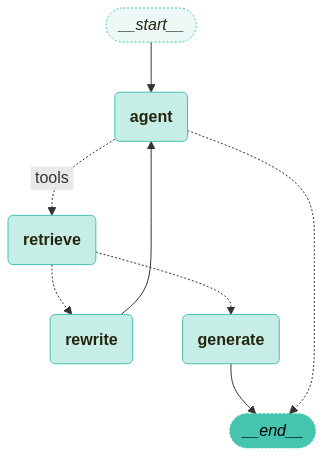

In [319]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [321]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

for event in graph.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('\n--------------------- [for 시작] ------------------------------')
        print(f"[노드 이름] : {node_name}")
        print('[노드 value]:\n', node_chunk)
        # print(f"messages: {node_chunk['messages']}")
        # print(f"content: {node_chunk['messages'][-1].content}")
        # print(f"additional_kwargs: {node_chunk['messages'][-1].additional_kwargs}")
        print('\n--------------------- [for  끝]  ------------------------------')
        print()

agent() 함수 실행: 
전달받은 state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 개발한 생성형 AI 의 이름은?', additional_kwargs={}, response_metadata={}, id='27f836d3-42c9-4de2-9834-3ae8c0d4a8b0')]

--------------------- [for 시작] ------------------------------
[노드 이름] : agent
[노드 value]:
 {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_3pymIqg4vfyUk1SLAxl0BcRC', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306'}, id='run-b3382782-631e-41a7-934b-5a8772145f06-0', tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_3pymIqg4vfyUk1SLAxl0BcRC', 'type': 'tool_call'}])]}

--------------------- [for  끝]  ------------------------------

grade_documents() 함수 실행: 
state['message'] 를 꺼낸다
원래 질문 : 삼성전자가 개발한 생성형 AI 의 이름은?
가장 마지막 질문: 
content='<document><cont

In [322]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

# 그래프 실행
invoke_graph(graph, inputs, config)

agent() 함수 실행: 
전달받은 state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 개발한 생성형 AI 의 이름은?', additional_kwargs={}, response_metadata={}, id='cee409cb-5721-40cd-9e74-130f9155f733')]

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_37QfZzV4PAMASHRc82Zj7vf4)
 Call ID: call_37QfZzV4PAMASHRc82Zj7vf4
  Args:
    query: 삼성전자 생성형 AI 이름
grade_documents() 함수 실행: 
state['message'] 를 꺼낸다
원래 질문 : 삼성전자가 개발한 생성형 AI 의 이름은?
가장 마지막 질문: 
content='<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>\n\n<document><context>SPRi AI Brief |\n2

In [323]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

# 그래프 스트리밍 출력
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])

agent() 함수 실행: 
전달받은 state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 개발한 생성형 AI 의 이름은?', additional_kwargs={}, response_metadata={}, id='d91a43ee-9396-4926-b3bc-6b62c43a8b9f')]

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
grade_documents() 함수 실행: 
state['message'] 를 꺼낸다
원래 질문 : 삼성전자가 개발한 생성형 AI 의 이름은?
가장 마지막 질문: 
content='<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>\n\n<document><context>SPRi AI Brief |\n2023-12월호\n삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\nKEY Contents\nn 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\nAI 모델 ‘삼성 가우스’를 공개\nn 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n삼성 가우스는 외부로 사용자 정보가 유출될 위험이

In [324]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "대한민국의 수도는?"),
    ]
}

# 그래프 실행
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])

agent() 함수 실행: 
전달받은 state 에서 꺼내온 messages:
[HumanMessage(content='대한민국의 수도는?', additional_kwargs={}, response_metadata={}, id='43eb8e1f-db80-419a-8be2-1d3a2bcaf92b')]

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
대한민국의 수도는 서울입니다.=================================================================================
